
# Conformal Prediction for Time Series: A Comparison

**Dataset:** AirPassengers (1949–1960)  
**Target coverage:** 90%  

Each method is implemented **independently**:
- Separate training
- Separate calibration
- Separate plots
- Separate evaluation

Forecasting backbone:
- ARIMA for non-Kalman methods
- State-space + Kalman recursion for KalmanCQR



## Baseline CQR (ARIMA residuals)


PICP (coverage): 0.733
PIW (avg width): 36.75


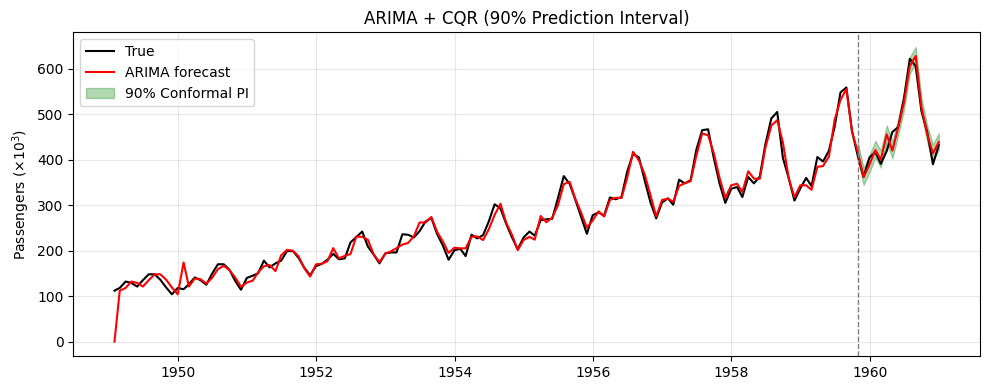

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import QuantileRegressor

# -----------------------------
# Data
# -----------------------------
air_passengers_data = [
    112,118,132,129,121,135,148,148,136,119,104,118,
    115,126,141,135,125,149,170,170,158,133,114,140,
    145,150,178,163,172,178,199,199,184,162,146,166,
    171,180,193,181,183,218,230,242,209,191,172,194,
    196,196,236,235,229,243,264,272,237,211,180,201,
    204,188,235,227,234,264,302,293,259,229,203,229,
    242,233,267,269,270,315,364,347,312,274,237,278,
    284,277,317,313,318,374,413,405,355,306,271,306,
    315,301,356,348,355,422,465,467,404,347,305,336,
    340,318,362,348,363,435,491,505,404,359,310,337,
    360,342,406,396,420,472,548,559,463,407,362,405,
    417,391,419,461,472,535,622,606,508,461,390,432
]

dates = pd.date_range(start="1949-01", periods=len(air_passengers_data), freq="ME")
y = pd.Series(air_passengers_data, index=dates)

# -----------------------------
# ARIMA backbone
# -----------------------------
model = ARIMA(
    y,
    order=(0,1,1),
    seasonal_order=(0,1,1,12)
).fit()

y_pred = model.fittedvalues
residuals = y - y_pred

# -----------------------------
# CQR on residuals
# -----------------------------
valid = ~residuals.isna()
t = np.arange(len(y))[valid].reshape(-1, 1)
r = residuals[valid].values
y_valid = y[valid].values
y_pred_valid = y_pred[valid].values

n = len(r)
train_end = int(0.8 * n)
calib_end = int(0.9 * n)

X_train, r_train = t[:train_end], r[:train_end]
X_calib, r_calib = t[train_end:calib_end], r[train_end:calib_end]
X_test,  r_test  = t[calib_end:], r[calib_end:]
y_test = y_valid[calib_end:]
y_pred_test = y_pred_valid[calib_end:]

alpha = 0.10   # 90% coverage

qr_lo = QuantileRegressor(
    quantile=alpha/2, alpha=0, solver="highs"
).fit(X_train, r_train)

qr_hi = QuantileRegressor(
    quantile=1-alpha/2, alpha=0, solver="highs"
).fit(X_train, r_train)

# Calibration scores
lo_cal = qr_lo.predict(X_calib)
hi_cal = qr_hi.predict(X_calib)
scores = np.maximum(r_calib - hi_cal, lo_cal - r_calib)
qhat = np.quantile(scores, 1 - alpha)

# Final intervals
lo_test = qr_lo.predict(X_test)
hi_test = qr_hi.predict(X_test)

lower = y_pred_test + lo_test - qhat
upper = y_pred_test + hi_test + qhat

# -----------------------------
# Metrics
# -----------------------------
PICP = np.mean((y_test >= lower) & (y_test <= upper))
PIW = np.mean(upper - lower)

print(f"PICP (coverage): {PICP:.3f}")
print(f"PIW (avg width): {PIW:.2f}")

# -----------------------------
# Final plot (same style)
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(y, color="black", label="True")
plt.plot(y_pred, color="red", label="ARIMA forecast")

plt.fill_between(
    y.index[valid][calib_end:],
    lower,
    upper,
    color="green",
    alpha=0.30,
    label="90% Conformal PI"
)

plt.axvline(
    y.index[valid][calib_end],
    color="gray",
    linestyle="--",
    linewidth=1
)

plt.title("ARIMA + CQR (90% Prediction Interval)")
plt.ylabel(r"Passengers ($\times 10^3$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('temporal_plots/Arima_CQR.pdf', format='pdf', dpi=600)
plt.show()


## ACI-CQR (Adaptive Quantile Update)


ACI-CQR PICP: 0.733
ACI-CQR PIW : 36.83


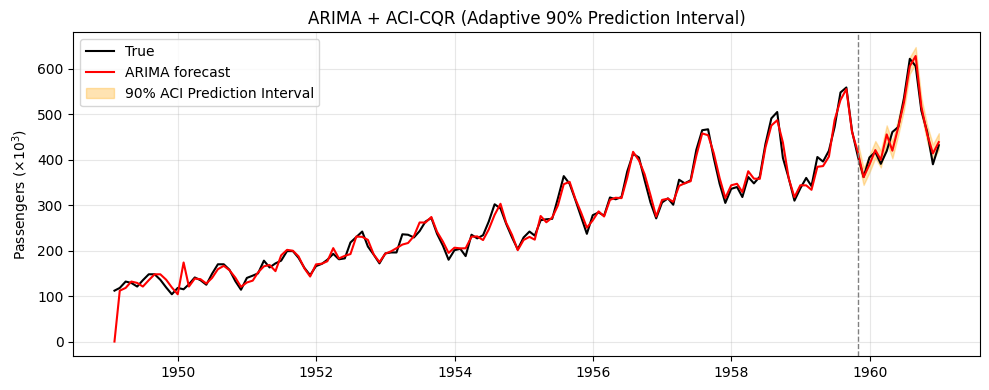

In [49]:
# ==============================
# ACI-CQR (Adaptive Conformal)
# Linear Quantile Regression
# ==============================

# Reuse objects from previous cell:
# y, y_pred, residuals, valid, alpha

from sklearn.linear_model import QuantileRegressor
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Prepare data (same split)
# -----------------------------
t = np.arange(len(y))[valid].reshape(-1, 1)
r = residuals[valid].values
y_valid = y[valid].values
y_pred_valid = y_pred[valid].values

n = len(r)
train_end = int(0.8 * n)
calib_end = int(0.9 * n)

X_train, r_train = t[:train_end], r[:train_end]
X_calib, r_calib = t[train_end:calib_end], r[train_end:calib_end]
X_test  = t[calib_end:]
y_test  = y_valid[calib_end:]
y_pred_test = y_pred_valid[calib_end:]

# -----------------------------
# Fit quantile regressors
# -----------------------------
qr_lo = QuantileRegressor(
    quantile=alpha/2, alpha=0, solver="highs"
).fit(X_train, r_train)

qr_hi = QuantileRegressor(
    quantile=1-alpha/2, alpha=0, solver="highs"
).fit(X_train, r_train)

# -----------------------------
# Initial calibration (q̂₀)
# -----------------------------
lo_cal = qr_lo.predict(X_calib)
hi_cal = qr_hi.predict(X_calib)

scores_cal = np.maximum(
    r_calib - hi_cal,
    lo_cal - r_calib
)

q_t = np.quantile(scores_cal, 1 - alpha)

# -----------------------------
# ACI recursion on test set
# -----------------------------
gamma = 0.05   # adaptation rate (stable choice)

lower, upper = [], []
errors = []

for i in range(len(X_test)):
    lo = y_pred_test[i] + qr_lo.predict(X_test[i:i+1])[0] - q_t
    hi = y_pred_test[i] + qr_hi.predict(X_test[i:i+1])[0] + q_t

    lower.append(lo)
    upper.append(hi)

    err = not (y_test[i] >= lo and y_test[i] <= hi)
    errors.append(err)

    # ACI update
    q_t = max(0.0, q_t + gamma * (err - alpha))

lower = np.array(lower)
upper = np.array(upper)

# -----------------------------
# Metrics
# -----------------------------
PICP_aci = 1 - np.mean(errors)
PIW_aci = np.mean(upper - lower)

print(f"ACI-CQR PICP: {PICP_aci:.3f}")
print(f"ACI-CQR PIW : {PIW_aci:.2f}")

# -----------------------------
# Plot (same style)
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(y, color="black", label="True")
plt.plot(y_pred, color="red", label="ARIMA forecast")

plt.fill_between(
    y.index[valid][calib_end:],
    lower,
    upper,
    color="orange",
    alpha=0.30,
    label="90% ACI Prediction Interval"
)

plt.axvline(
    y.index[valid][calib_end],
    color="gray",
    linestyle="--",
    linewidth=1
)

plt.title("ARIMA + ACI-CQR (Adaptive 90% Prediction Interval)")
plt.ylabel(r"Passengers ($\times 10^3$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('temporal_plots/ACI.pdf', format='pdf', dpi=600)
plt.show()


## EnbPI (Bootstrap Residuals)


Ensemble PICP: 0.733
Ensemble PIW : 36.19


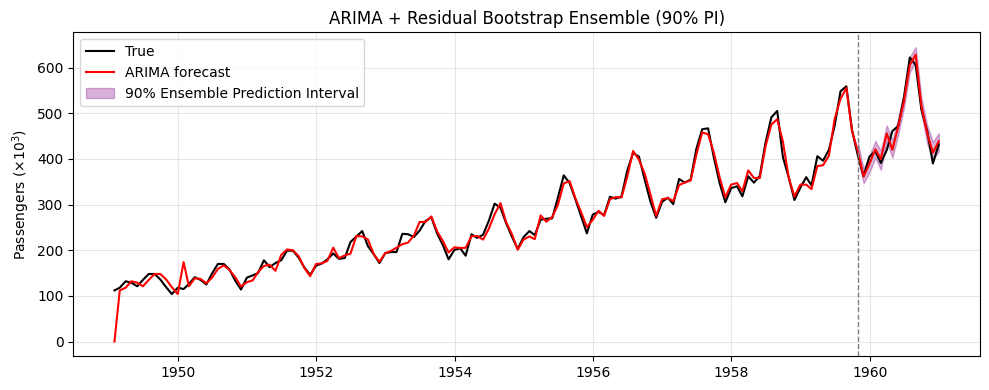

In [50]:
# ==============================
# Ensemble Batch Prediction Intervals (Residual Bootstrap)
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Fit base ARIMA
from statsmodels.tsa.arima.model import ARIMA
model_base = ARIMA(y, order=(0,1,1), seasonal_order=(0,1,1,12)).fit()
y_pred = model_base.fittedvalues
residuals = y - y_pred
valid = ~residuals.isna()

# -----------------------------
# Same split as ACI-CQR
# -----------------------------
y_valid = y[valid].values
y_pred_valid = y_pred[valid].values
r = residuals[valid].values

n = len(r)
train_end = int(0.8 * n)
calib_end = int(0.9 * n)

y_test = y_valid[calib_end:]
y_pred_test = y_pred_valid[calib_end:]

# -----------------------------
# Residual Bootstrap Ensemble (STABLE)
# -----------------------------
B = 200  # more members for stable quantiles
alpha = 0.10
np.random.seed(42)

ensemble_forecasts = []

for b in range(B):
    # Sample residuals WITH replacement (same length as valid period)
    boot_resid = np.random.choice(r, size=n, replace=True)
    # Construct ensemble forecast: base forecast + bootstrapped residual
    y_ens = y_pred_valid + boot_resid
    # Extract test portion
    ensemble_forecasts.append(y_ens[calib_end:])

ensemble_forecasts = np.array(ensemble_forecasts)  # shape: (B, len_test)

# -----------------------------
# Compute PI
# -----------------------------
lower = np.quantile(ensemble_forecasts, alpha/2, axis=0)
upper = np.quantile(ensemble_forecasts, 1 - alpha/2, axis=0)

# -----------------------------
# Metrics
# -----------------------------
covered = (y_test >= lower) & (y_test <= upper)
PICP_ens = np.mean(covered)
PIW_ens = np.mean(upper - lower)

print(f"Ensemble PICP: {PICP_ens:.3f}")
print(f"Ensemble PIW : {PIW_ens:.2f}")

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(y, color="black", label="True")
plt.plot(y_pred, color="red", label="ARIMA forecast")

plt.fill_between(
    y.index[valid][calib_end:],
    lower,
    upper,
    color="purple",
    alpha=0.30,
    label="90% Ensemble Prediction Interval"
)

plt.axvline(
    y.index[valid][calib_end],
    color="gray",
    linestyle="--",
    linewidth=1
)

plt.title("ARIMA + Residual Bootstrap Ensemble (90% PI)")
plt.ylabel(r"Passengers ($\times 10^3$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('temporal_plots/EnbPI.pdf', format='pdf', dpi=600)
plt.show()

Ensemble CQR PICP: 0.733
Ensemble CQR PIW : 37.76


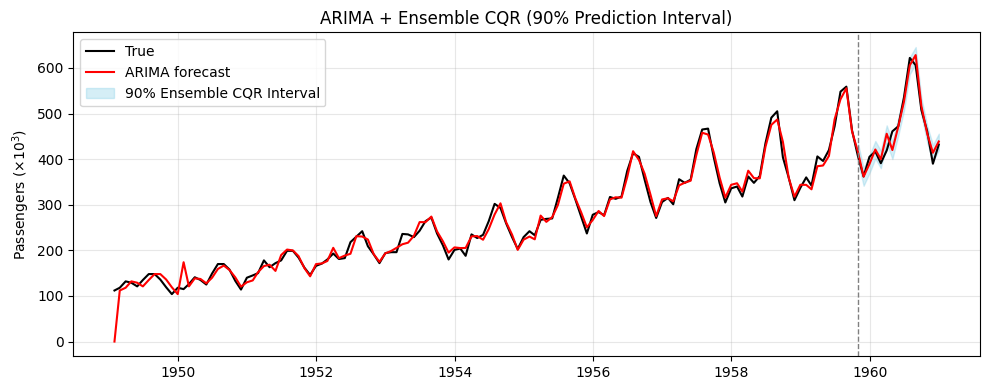

In [51]:
# ==============================
# Ensemble Conformalized Quantile Regression (Ensemble CQR)
# ==============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor


# Fit ARIMA
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y, order=(0,1,1), seasonal_order=(0,1,1,12)).fit()
y_pred = model.fittedvalues
residuals = y - y_pred
valid = ~residuals.isna()

# -----------------------------
# Prepare data (same split as before)
# -----------------------------
t = np.arange(len(y))[valid].reshape(-1, 1)
r = residuals[valid].values
y_valid = y[valid].values
y_pred_valid = y_pred[valid].values

n = len(r)
train_end = int(0.8 * n)
calib_end = int(0.9 * n)

X_train, r_train = t[:train_end], r[:train_end]
X_calib, r_calib = t[train_end:calib_end], r[train_end:calib_end]
X_test = t[calib_end:]
y_test = y_valid[calib_end:]
y_pred_test = y_pred_valid[calib_end:]

alpha = 0.10  # 90% PI

# -----------------------------
# Ensemble CQR: Bootstrap QR models
# -----------------------------
B = 100  # number of ensemble members
np.random.seed(42)

# Store predictions on calibration and test sets
lo_cal_ens = []
hi_cal_ens = []
lo_test_ens = []
hi_test_ens = []

for b in range(B):
    # Bootstrap sample from training data (with replacement)
    n_train = len(X_train)
    idx_boot = np.random.choice(n_train, size=n_train, replace=True)
    X_boot = X_train[idx_boot]
    r_boot = r_train[idx_boot]

    # Fit QR models on bootstrap sample
    try:
        qr_lo = QuantileRegressor(quantile=alpha/2, alpha=0, solver="highs").fit(X_boot, r_boot)
        qr_hi = QuantileRegressor(quantile=1-alpha/2, alpha=0, solver="highs").fit(X_boot, r_boot)

        lo_cal_ens.append(qr_lo.predict(X_calib))
        hi_cal_ens.append(qr_hi.predict(X_calib))
        lo_test_ens.append(qr_lo.predict(X_test))
        hi_test_ens.append(qr_hi.predict(X_test))
    except:
        continue  # skip if solver fails (rare)

# Convert to arrays
lo_cal_ens = np.array(lo_cal_ens)   # (B, n_calib)
hi_cal_ens = np.array(hi_cal_ens)
lo_test_ens = np.array(lo_test_ens) # (B, n_test)
hi_test_ens = np.array(hi_test_ens)

# Average ensemble predictions (or median — averaging is fine for linear QR)
lo_cal_avg = np.mean(lo_cal_ens, axis=0)
hi_cal_avg = np.mean(hi_cal_ens, axis=0)
lo_test_avg = np.mean(lo_test_ens, axis=0)
hi_test_avg = np.mean(hi_test_ens, axis=0)

# -----------------------------
# Conformal calibration (single q̂)
# -----------------------------
scores_cal = np.maximum(r_calib - hi_cal_avg, lo_cal_avg - r_calib)
qhat = np.quantile(scores_cal, 1 - alpha)

# Final prediction intervals
lower = y_pred_test + lo_test_avg - qhat
upper = y_pred_test + hi_test_avg + qhat

# -----------------------------
# Metrics
# -----------------------------
covered = (y_test >= lower) & (y_test <= upper)
PICP_ecqr = np.mean(covered)
PIW_ecqr = np.mean(upper - lower)

print(f"Ensemble CQR PICP: {PICP_ecqr:.3f}")
print(f"Ensemble CQR PIW : {PIW_ecqr:.2f}")

# -----------------------------
# Plot (same style)
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(y, color="black", label="True")
plt.plot(y_pred, color="red", label="ARIMA forecast")

plt.fill_between(
    y.index[valid][calib_end:],
    lower,
    upper,
    color="#74c8e3",
    alpha=0.30,
    label="90% Ensemble CQR Interval"
)

plt.axvline(
    y.index[valid][calib_end],
    color="gray",
    linestyle="--",
    linewidth=1
)

plt.title("ARIMA + Ensemble CQR (90% Prediction Interval)")
plt.ylabel(r"Passengers ($\times 10^3$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('temporal_plots/EnCQR.pdf', format='pdf', dpi=600)
plt.show()


## KalmanCQR (Innovation-Based Conformal)


PICP (coverage): 0.933
PIW (avg width): 189.63


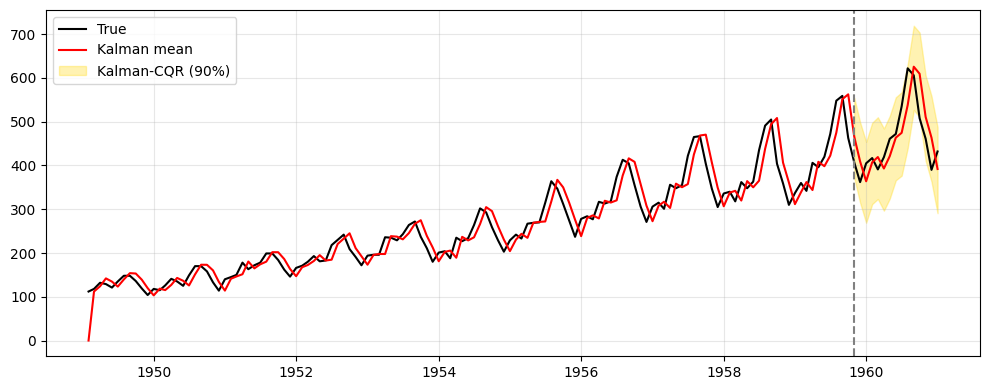

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents
import statsmodels.api as sm

# -----------------------------
# Data
# -----------------------------
air_passengers_data = [
    112,118,132,129,121,135,148,148,136,119,104,118,
    115,126,141,135,125,149,170,170,158,133,114,140,
    145,150,178,163,172,178,199,199,184,162,146,166,
    171,180,193,181,183,218,230,242,209,191,172,194,
    196,196,236,235,229,243,264,272,237,211,180,201,
    204,188,235,227,234,264,302,293,259,229,203,229,
    242,233,267,269,270,315,364,347,312,274,237,278,
    284,277,317,313,318,374,413,405,355,306,271,306,
    315,301,356,348,355,422,465,467,404,347,305,336,
    340,318,362,348,363,435,491,505,404,359,310,337,
    360,342,406,396,420,472,548,559,463,407,362,405,
    417,391,419,461,472,535,622,606,508,461,390,432
]

dates = pd.date_range(start="1949-01", periods=len(air_passengers_data), freq="ME")
y = pd.Series(air_passengers_data, index=dates)

# -----------------------------
# Kalman model
# -----------------------------
model = UnobservedComponents(
    y,
    level="local linear trend"
)

res = model.fit(disp=False)

# -----------------------------
# ### NEW: use INNOVATIONS (one-step-ahead forecast errors)
# -----------------------------
innov = res.filter_results.forecasts_error[0]
innov = pd.Series(innov, index=y.index)

valid = ~innov.isna()
innov = innov[valid]
y_valid = y[valid]
y_pred = res.filter_results.forecasts[0][valid]

# -----------------------------
# Split
# -----------------------------
n = len(innov)
train_end = int(0.8 * n)
calib_end = int(0.9 * n)

innov_train = innov[:train_end]
innov_calib = innov[train_end:calib_end]
innov_test = innov[calib_end:]

y_pred_test = y_pred[calib_end:]
y_test = y_valid[calib_end:]

# -----------------------------
# ### NEW: Quantile regression on innovations
# -----------------------------
t = np.arange(len(innov)).reshape(-1, 1)
X = sm.add_constant(t)

alpha = 0.10
qr_lo = sm.QuantReg(innov, X).fit(q=alpha / 2)
qr_hi = sm.QuantReg(innov, X).fit(q=1 - alpha / 2)

q_lo = qr_lo.predict(X)
q_hi = qr_hi.predict(X)

# -----------------------------
# ### NEW: CQR calibration (asymmetric)
# -----------------------------
cal_scores = np.maximum(
    q_lo[train_end:calib_end] - innov_calib,
    innov_calib - q_hi[train_end:calib_end]
)

q_hat = np.quantile(cal_scores, 1 - alpha)

# -----------------------------
# Final prediction intervals
# -----------------------------
lower = y_pred_test + q_lo[calib_end:] - q_hat
upper = y_pred_test + q_hi[calib_end:] + q_hat

# -----------------------------
# Metrics
# -----------------------------
PICP = np.mean((y_test >= lower) & (y_test <= upper))
PIW = np.mean(upper - lower)

print(f"PICP (coverage): {PICP:.3f}")
print(f"PIW (avg width): {PIW:.2f}")

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(y, color="black", label="True")
plt.plot(y.index[valid], y_pred, color="red", label="Kalman mean")

plt.fill_between(
    y.index[valid][calib_end:],
    lower,
    upper,
    color="gold",
    alpha=0.30,
    label="Kalman-CQR (90%)"
)

plt.axvline(y.index[valid][calib_end], color="gray", linestyle="--")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Rolling CQR with Kalman

PICP (coverage): 0.733
PIW (avg width): 562.73


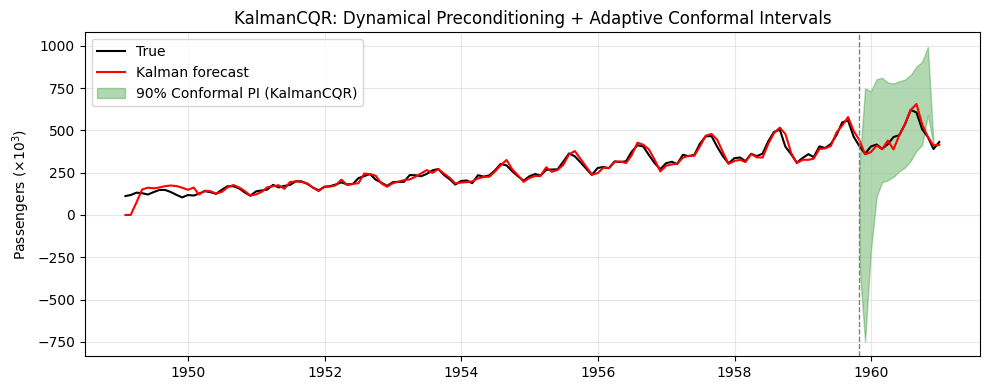

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents

# -----------------------------
# Data
# -----------------------------
air_passengers_data = [
    112,118,132,129,121,135,148,148,136,119,104,118,
    115,126,141,135,125,149,170,170,158,133,114,140,
    145,150,178,163,172,178,199,199,184,162,146,166,
    171,180,193,181,183,218,230,242,209,191,172,194,
    196,196,236,235,229,243,264,272,237,211,180,201,
    204,188,235,227,234,264,302,293,259,229,203,229,
    242,233,267,269,270,315,364,347,312,274,237,278,
    284,277,317,313,318,374,413,405,355,306,271,306,
    315,301,356,348,355,422,465,467,404,347,305,336,
    340,318,362,348,363,435,491,505,404,359,310,337,
    360,342,406,396,420,472,548,559,463,407,362,405,
    417,391,419,461,472,535,622,606,508,461,390,432
]

dates = pd.date_range(start="1949-01", periods=len(air_passengers_data), freq="ME")
y = pd.Series(air_passengers_data, index=dates)

# -----------------------------
# Train / Calibration / Test split (80/10/10)
# -----------------------------
n = len(y)
train_end = int(0.8 * n)
calib_end = int(0.9 * n)

train = y.iloc[:train_end]
calib = y.iloc[train_end:calib_end]
test = y.iloc[calib_end:]

# -----------------------------
# Fit Kalman filter on TRAINING data only
# -----------------------------
kf_model = UnobservedComponents(
    train,
    level='local linear trend',
    seasonal=12,
    freq='ME'
).fit(disp=False)

# -----------------------------
# Apply model to CALIBRATION set (out-of-sample one-step-ahead forecasts)
# -----------------------------
calib_res = kf_model.apply(calib)

y_calib_pred = calib_res.fittedvalues
innov_calib = calib - y_calib_pred

# Extract forecast error variance: Var(e_t) = F_t
# Shape: (k_endog, k_endog, nobs) → univariate → [0, 0, :]
F_calib = calib_res.filter_results.forecasts_error_cov[0, 0, :]

# Normalize innovations by predicted std dev
norm_innov_calib = innov_calib.values / np.sqrt(F_calib + 1e-8)

# -----------------------------
# Conformal calibration
# -----------------------------
alpha = 0.10  # for 90% prediction interval
q_hat = np.quantile(np.abs(norm_innov_calib), 1 - alpha)

# -----------------------------
# Forecast on TEST set
# -----------------------------
test_res = kf_model.apply(test)
y_test_pred = test_res.fittedvalues
F_test = test_res.filter_results.forecasts_error_cov[0, 0, :]

# Scale conformal bound by Kalman's predicted uncertainty
lower = y_test_pred - q_hat * np.sqrt(F_test)
upper = y_test_pred + q_hat * np.sqrt(F_test)

# -----------------------------
# Evaluation metrics
# -----------------------------
PICP = np.mean((test.values >= lower.values) & (test.values <= upper.values))
PIW = np.mean(upper.values - lower.values)

print(f"PICP (coverage): {PICP:.3f}")
print(f"PIW (avg width): {PIW:.2f}")

# -----------------------------
# Plotting (same style as original)
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(y, color="black", label="True")

# Full in-sample + out-of-sample forecast for visual continuity
full_forecast = kf_model.apply(y).fittedvalues
plt.plot(full_forecast, color="red", label="Kalman forecast")

plt.fill_between(
    test.index,
    lower,
    upper,
    color="green",
    alpha=0.30,
    label="90% Conformal PI (KalmanCQR)"
)

plt.axvline(test.index[0], color="gray", linestyle="--", linewidth=1)
plt.title("KalmanCQR: Dynamical Preconditioning + Adaptive Conformal Intervals")
plt.ylabel(r"Passengers ($\times 10^3$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# PICP vs PIW

C:\Users\hossa\AppData\Local\Temp\ipykernel_36768\1952116278.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


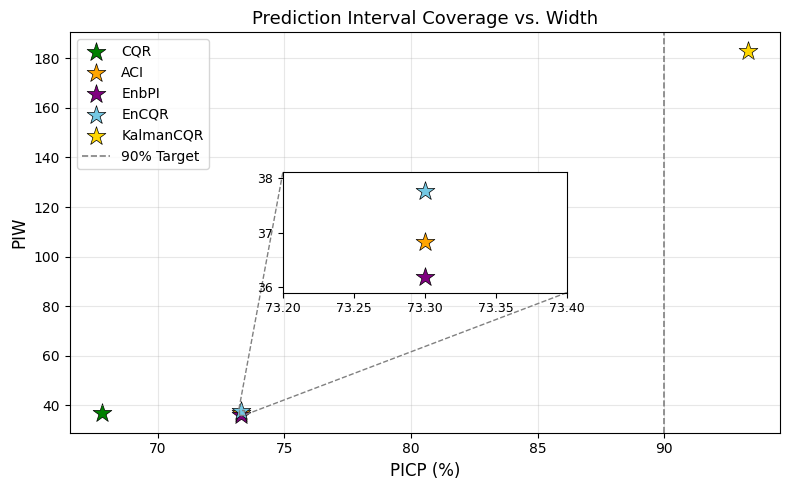

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# -----------------------------
# Your results
# -----------------------------
methods = {
    "CQR":         {"color": "green",      "marker": "*", "pos": (67.8, 36.75)},
    "ACI":         {"color": "orange",     "marker": "*", "pos": (73.3, 36.83)},
    "EnbPI":       {"color": "purple",     "marker": "*", "pos": (73.3, 36.19)},
    "EnCQR":       {"color": "#74c8e3",    "marker": "*", "pos": (73.3, 37.76)},
    "KalmanCQR":   {"color": "gold",       "marker": "*", "pos": (93.3, 189.63)}
}

names = list(methods.keys())
picp_vals = [methods[name]["pos"][0] for name in names]
piw_vals = [methods[name]["pos"][1] for name in names]
colors = [methods[name]["color"] for name in names]

# -----------------------------
# Main plot
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 5))

for i, name in enumerate(names):
    ax.scatter(
        picp_vals[i], piw_vals[i],
        color=colors[i],
        s=200,
        marker='*',
        label=name,
        edgecolors='k',
        linewidth=0.5
    )

# Vertical line at 90% PICP
ax.axvline(x=90, color='gray', linestyle='--', linewidth=1.2, label='90% Target')

# Labels
ax.set_xlabel('PICP (%)', fontsize=12)
ax.set_ylabel('PIW', fontsize=12)
ax.set_title('Prediction Interval Coverage vs. Width', fontsize=13)
ax.grid(True, alpha=0.3)

# -----------------------------
# Inset axes (zoom on low-PIW cluster)
# -----------------------------
# Define inset location and size
axins = inset_axes(ax, width="40%", height="30%", loc='center', borderpad=2)

# Plot only the four methods near 73.3%
cluster_methods = ["CQR", "ACI", "EnbPI", "EnCQR"]
for name in cluster_methods:
    pos = methods[name]["pos"]
    axins.scatter(
        pos[0], pos[1],
        color=methods[name]["color"],
        s=200,
        marker='*',
        edgecolors='k',
        linewidth=0.5
    )

# Set tight limits around the cluster
x_margin = 0.1
y_margin = 0.5
axins.set_xlim(73.3 - x_margin, 73.3 + x_margin)
axins.set_ylim(35.9, 38.1)

# Optional: remove tick labels for cleaner look (or keep them)
axins.tick_params(labelsize=9)

# Draw connecting lines (zoom indicator)
# We'll connect the inset to the region around (73.3, ~36–38)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", linestyle='--', linewidth=1)

# Legend
ax.legend()
plt.tight_layout()

# Save and show
plt.savefig('temporal_plots/PICP_vs_PIW.pdf', format='pdf', dpi=600)
plt.show()